# simulating a migrating population of bacteria 

In [1]:
import os

import itertools

from Bio import SeqIO, AlignIO

import gzip
import csv

import subprocess, gzip, tempfile
import shutil

from concurrent.futures import ProcessPoolExecutor, as_completed
import warnings

from tqdm.notebook import tqdm

In [2]:
import tsinfer
import tskit
import msprime
import tsdate

import numpy as np
import pandas as pd

import datetime as dt
import time

import matplotlib.pyplot as plt
%matplotlib inline 

# from sklearn.linear_model import LinearRegression
from itertools import combinations
import random 

# [!Note](https://tskit.dev/msprime/docs/latest/demography.html#model)

Migration is described from the perspective of the coalescent, so that when describing migrations in msprime, the following reversed terminology holds:

destination (or dest):
The population containing the immediate ancestors of the migrant(s). Forwards in time, this is where migrants come from. In reverse time, a lineage that is traced backwards in time (i.e. from the current day into the past) will appear to jump into this ancestral destination at the precise time of the migration event.

source:
The population containing the immediate descendants of the migrants. Forwards in time, this is where migrants end up. In reverse time, a lineage traced backwards from the current day will appear to jump from this population into the ancestral (“destination”) population.

## (1) source-sink island model (contemporaneous, recombinant)

In [136]:
def sim_ss(length, rr, mu, seed, migration_rate, min_samples, max_samples): #num_sinks, num_populations, sample_sizes, migration_rates, effective_Nes, ): 
    
    
    num_sinks = num_populations - 1
    sizes = [4e3] + [1e3] * num_sinks # constant Ne = [3000.0, 1000.0, 1000.0]
    bg = 1e-6 #background migration rate [everywhere to everywhere] 
    demography = msprime.Demography.island_model(initial_size=sizes, migration_rate=bg)

    src_sink = migration_rate # source to sink mig rate
    sink_src = src_sink/10
    sink_sink = sink_src*2
    #sink_src = 1e-4 # sink to source mig rate
    #sink_sink = 2e-4 # sink to sink mig rate

    # source <-> sink, assymetric
    for sink_id in range(1, num_sinks + 1):
        demography.set_migration_rate(source=0,       dest=sink_id, rate=sink_src)  # sink -> source (backwards in time)
        demography.set_migration_rate(source=sink_id, dest=0,       rate=src_sink)  # source -> sink (backwards in time)

    # sink <-> sink, symmetric 
    sink_ids = list(range(1, num_sinks + 1))
    demography.set_symmetric_migration_rate(populations=sink_ids, rate=sink_sink)

    # random sampling
    sample_counts = {} 
    for i in range(0, num_populations): 
        sample_counts[i] = random.randint(min_samples,max_samples)

    sample_set = [msprime.SampleSet(n, population=pop) for pop, n in sample_counts.items()]

    # simulate ancestry 
    ts = msprime.sim_ancestry(
        samples=sample_set,
        demography=demography,
        sequence_length=length,
        recombination_rate=rr,
        random_seed=seed,
        record_migrations = True,
        ploidy = 1
    )
    
    ts = msprime.sim_mutations(ts, rate=mu, random_seed=seed)
    samples = list(ts.samples())

    # get ancestral states
    ancestral_states = []
    
    for site in ts.sites():
        if site.ancestral_state is None:
            ancestral_states.append("N")
            #print("N")
        else:
            ancestral_states.append(str(site.ancestral_state))
            #print(site.ancestral_state)
    
    ancestral_states = np.array(ancestral_states)

    # parameters for inference
    sample_nodes = np.array(list(ts.samples()), dtype=int)
    individuals_time = ts.tables.nodes.time[sample_nodes]

    return ts, samples, ancestral_states, individuals_time 

## (2) symmetric migration island model (contemporaneous, recombinant)

In [137]:
def sim_eq(length, rr, mu, seed, migration_rate, min_samples, max_samples): #num_populations, sample_sizes, migration_rate, effective_Ne, ): 
    
    num_populations = 3
    sizes = [3e3] * num_populations # constant Ne = [3000.0]
    bg = 1e-6 #background migration rate [everywhere to everywhere] 
    demography = msprime.Demography.island_model(initial_size=sizes, migration_rate=bg)
    
    # all <-> all, symmetric 
    demes = list(range(0, num_populations))
    demography.set_symmetric_migration_rate(populations=demes, rate=migration_rate) ##### careful! need to set all to all explicitly

    # random sampling
    sample_counts = {} 
    for i in range(0, num_populations): 
        sample_counts[i] = random.randint(min_samples,max_samples)

    sample_set = [msprime.SampleSet(n, population=pop) for pop, n in sample_counts.items()]
    
    # simulate ancestry 
    ts = msprime.sim_ancestry(
        samples= sample_set,
        demography=demography,
        sequence_length=length,
        recombination_rate=rr,
        random_seed=seed,
        record_migrations = True,
        ploidy = 1
    )
    
    ts = msprime.sim_mutations(ts, rate=mu, random_seed=seed)
    samples = list(ts.samples())

    # get ancestral states
    ancestral_states = []
    
    for site in ts.sites():
        if site.ancestral_state is None:
            ancestral_states.append("N")
            #print("N")
        else:
            ancestral_states.append(str(site.ancestral_state))
            #print(site.ancestral_state)
    
    ancestral_states = np.array(ancestral_states)

    # parameters for inference
    sample_nodes = np.array(list(ts.samples()), dtype=int)
    individuals_time = ts.tables.nodes.time[sample_nodes]

    return ts, samples, ancestral_states, individuals_time 

## finding location of mrca for every pair of tips in every tree 

In [53]:
def get_locations_df(ts, samples, kind = 'src_snk', trim_flanks = True): 
    type = "inf" 
    if trim_flanks == False:
        type = "sim"
    
    rows = []
    start = 1 if (trim_flanks and ts.num_trees > 2) else 0
    end   = ts.num_trees - 1 if (trim_flanks and ts.num_trees > 2) else ts.num_trees
    for i in range(start, end):
        t = ts.at_index(i)
        L, R = t.interval

        for a, b in combinations(samples, 2):
            u = t.mrca(a, b)
            pop = ts.population(ts.node(u).population).metadata["name"]
            rows.append({
                "index": i, 
                "sample_a": a, 
                "sample_b": b,
                "left": L, 
                "right": R,
                "mrca_population": pop, 
                "type": type,
                "kind": kind,
                "node": u
            })
    return pd.DataFrame(rows)

## binning 

In [55]:
def make_edges(L, bin_size):
    return np.arange(bin_size/2, int(L) +(bin_size/2), bin_size, dtype=np.int64)
    #return np.arange(0, int(L) + bin_size, bin_size, dtype=np.int64)

def add_bins(df, positions):
    out = []
    
    for i, pos in enumerate(positions):
        mask = (df["left"] <= pos) & (pos < df["right"])   # half-open [left, right) like tskit intervals
        if mask.any():
            tmp = df.loc[mask].copy()
            tmp["bin"] = i
            tmp["position"] = int(pos)
            out.append(tmp)
            
    return pd.concat(out, ignore_index=True)

# core functions

### export/import simulated ts

In [154]:
def fmt_sci(x):
    s = f"{x:.3e}"
    s = s.replace("+0", "+").replace("-0", "-") # reformatting numbers
    return s

def vcz_name(prefix, mu, migration_rate, seed):
    return f"{prefix}_mu{fmt_sci(mu)}_mr{fmt_sci(migration_rate)}_seed{seed}.vcf.gz.icf.vcz"

# export
def export_sim(prefix, ts, mu, migration_rate, seed, workdir=".", force=False):
    os.makedirs(workdir, exist_ok=True)

    base = os.path.join(workdir, vcz_name(prefix, mu, migration_rate, seed))             # ...vcf.gz.icf.vcz
    vcf_path   = base.replace(".vcf.gz.icf.vcz", ".vcf")
    vcfgz_path = base.replace(".icf.vcz", "")                                  # ...vcf.gz
    icf_path   = base.replace(".vcz", "")                                      # ...vcf.gz.icf

    # if .vcz exists, skip all
    if os.path.exists(base):
        return os.path.abspath(base)

    # if .icf exists, encode .vcz
    if os.path.exists(icf_path):
        cmd = ["vcf2zarr", "encode", icf_path, base]
        if force: cmd.append("--force")
        subprocess.run(cmd, check=True)
        return os.path.abspath(base)

    # if .vcf.gz, explode -> .icf and encode -> .vcz
    if os.path.exists(vcfgz_path):
        cmd = ["vcf2zarr", "explode", vcfgz_path, icf_path]
        if force: cmd.append("--force")
        subprocess.run(cmd, check=True)
        cmd = ["vcf2zarr", "encode", icf_path, base]
        if force: cmd.append("--force")
        subprocess.run(cmd, check=True)
        return os.path.abspath(base)

    # create .vcf, compress 
    if not os.path.exists(vcfgz_path):
        with tempfile.NamedTemporaryFile("w", delete=False, dir=workdir) as tmp:
            tmp_vcf = tmp.name
            ts.write_vcf(tmp, position_transform=lambda x: np.fmax(1, x))
        # compress
        if shutil.which("bgzip"):
            subprocess.run(["bgzip", "-f", tmp_vcf], check=True)
            # bgzip makes tmp_vcf + .gz
            os.replace(tmp_vcf + ".gz", vcfgz_path)
        else:
            with open(tmp_vcf, "rb") as fin, gzip.open(vcfgz_path, "wb") as fout:
                fout.write(fin.read())
            os.remove(tmp_vcf)

    # explode vcf.gz to icf
    if not os.path.exists(icf_path):
        cmd = ["vcf2zarr", "explode", vcfgz_path, icf_path]
        if force: cmd.append("--force")
        subprocess.run(cmd, check=True)

    # encode icf to vzc
    if not os.path.exists(base):
        cmd = ["vcf2zarr", "encode", icf_path, base]
        if force: cmd.append("--force")
        subprocess.run(cmd, check=True)

    return os.path.abspath(base)

In [129]:
def simulate_one_ss(length, rr, mu, seed, prefix, migration_rate, min_samples, max_samples):
    ts, samples, ancestral_states, individuals_time = sim_ss(length, rr, mu, seed, migration_rate, min_samples, max_samples)  # ground truth TS
    vcz_path = export_sim(prefix, ts, mu, migration_rate, seed, workdir="vcf_stage")
    return ts, samples, ancestral_states, vcz_path, individuals_time

In [130]:
def simulate_one_eq(length, rr, mu, seed, prefix, migration_rate, min_samples, max_samples):
    ts, samples, ancestral_states, individuals_time = sim_eq(length, rr, mu, seed, migration_rate, min_samples, max_samples)  # ground truth TS
    vcz_path = export_sim(prefix, ts, mu, migration_rate, seed, workdir="vcf_stage")
    return ts, samples, ancestral_states, vcz_path, individuals_time

use bio2zarr to convert VCF into VCZ/: 
```
source ~/tsinfer-env/bin/activate
gzip -k file.vcf
vcf2zarr explode file.vcf.gz file.icf
vcf2zarr encode file.icf file.vcz
```

# run inference

#### import, infer, date

In [66]:
# import vcz -> variant data object
def import_sim(vcz_path, ancestral_states, individuals_time):
    vdata = tsinfer.VariantData(
        vcz_path,
        ancestral_state=np.asarray(ancestral_states),
        individuals_time=np.asarray(individuals_time),
    )
    return vdata

In [68]:
def run_inference(vdata, rr, mu): 
    anc = tsinfer.generate_ancestors(vdata)
    anc_ts = tsinfer.match_ancestors(vdata, anc, recombination_rate = rr, mismatch_ratio = 1.0)
    ts = tsinfer.match_samples(vdata, anc_ts, recombination_rate = rr)
    simplified_ts = tsdate.preprocess_ts(ts, erase_flanks=False)

    dated_ts = tsdate.date(simplified_ts, 
                       mutation_rate=mu, 
                       time_units="generations", 
                       #return_fit=True,
                       match_segregating_sites = True
                       #rescaling_intervals = 492
                       )

    return dated_ts 

##### get df, bin etc

In [71]:
def get_locations_inf(ts, samples, kind = 'src_snk', trim_flanks = True): 
    type = "inf" 
    if trim_flanks == False:
        type = "sim"
    
    rows = []
    start = 1 if (trim_flanks and ts.num_trees > 2) else 0
    end   = ts.num_trees - 1 if (trim_flanks and ts.num_trees > 2) else ts.num_trees

    for i in range(start, end):
        t = ts.at_index(i)
        L, R = t.interval
        for a, b in combinations(samples, 2):
            u = t.mrca(a, b)
            pop = 'unlabeled'
            rows.append({
                "index": i, 
                "sample_a": a, 
                "sample_b": b,
                "left": L, 
                "right": R,
                "mrca_population": pop, 
                "type": type,
                "kind": kind,
                "node": u
            })
    return pd.DataFrame(rows)

### file naming

In [ ]:
def loc_file_name(prefix, mu, migration_rate, seed):
    return f"{prefix}_mu{fmt_sci(mu)}_mr{fmt_sci(migration_rate)}_seed{seed}.csv"

def trees_file_name(prefix, mu, migration_rate, seed):
    return f"{prefix}_mu{fmt_sci(mu)}_mr{fmt_sci(migration_rate)}_seed{seed}.trees"

# Sample from random parameters and simulate 

In [151]:
def run_cell(mu, rr, seed, prefix, migration_rate):

    #simulate, export 
    if prefix == "ss": 
        ts, samples, ancestral_states, vcz_path, individuals_time = simulate_one_ss(length, rr, mu, seed, prefix, migration_rate, min_samples, max_samples)

    else: #prefix == "eq"
        ts, samples, ancestral_states, vcz_path, individuals_time = simulate_one_eq(length, rr, mu, seed, prefix, migration_rate, min_samples, max_samples)
    
    loc_df = get_locations_df(ts, samples, trim_flanks = False)
    loc_binned = add_bins(loc_df, positions)
    
    #import, infer
    vdata = import_sim(f"vcf_stage/{vcz_name(prefix, mu, migration_rate, seed)}", ancestral_states, individuals_time)
    inf = run_inference(vdata, rr, mu)
    inf_loc = get_locations_inf(inf, samples, kind = prefix, trim_flanks = True)
    inf_loc_binned = add_bins(inf_loc, positions)
    
    #export 
    ## locations
    loc_binned.to_csv(f"locations/sim_{loc_file_name(prefix, mu, migration_rate, seed)}", index=False)
    inf_loc_binned.to_csv(f"locations/inf_{loc_file_name(prefix, mu, migration_rate, seed)}", index=False)
    
    ## trees
    ts.dump(f"trees/sim_{trees_file_name(prefix, mu, migration_rate, seed)}")
    inf.dump(f"trees/inf_{trees_file_name(prefix, mu, migration_rate, seed)}")

In [ ]:
def geo_sweep_parallel(MU_GRID, MIGRATION_RATES, N_RUNS, rr, seed, max_workers): 

    desc = f"Running {N_RUNS} simulations"

    # sample parameters
    jobs = []
    for i in range(N_RUNS):
        mu = random.choice(MU_GRID)
        migration_rate = random.choice(MIGRATION_RATES)
        prefix = random.choice(["ss", "ss", "eq"])
        seed = seed + i 

        jobs.append((mu, rr, seed, prefix, migration_rate))

    results = []
    failures = []

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(
                run_cell,
                mu=mu,
                rr=rr,
                seed=seed,
                prefix=prefix,
                migration_rate=migration_rate
            )
            for (mu, rr, seed, prefix, migration_rate) in jobs
        ]

    for fut in tqdm(as_completed(futures), total=len(futures), desc="simulations"):
            try:
                fut.result()  
                results.append("ok")
            except Exception as e:
                failures.append(str(e))

    return results, failures

    
    # with ProcessPoolExecutor(max_workers=max_workers) as ex:
    #     for i in range(0,N_RUNS): 
    #         mu = random.choice(MU_GRID)
    #         migration_rate = random.choice(MIGRATION_RATES)
    #         seed = random.Random(1) + i*3
    #         prefix = random.choice(['ss', 'ss', 'ss', 'eq'])
    #         ex.submit(run_cell, mu, rr, seed, prefix, migration_rate)
    
    #     #
    #     with tqdm(total=total, desc=desc, ncols=100) as pbar:
    #         # for fut in as_completed(futures):
    #             try:
    #                # a, b = fut.result()
    #                # inf_parts.append(a); null_parts.append(b)
    #             except Exception as e:
    #                 warnings.warn(f"worker failed: {e!r}")
    #             finally:
    #                     pbar.update(1)

    

    # return inf_all, null_all

In [7]:
seed = 15
length = 3e6
positions = make_edges(length, 1e5) #binning

rr = 1e-9 #recombination rate 
MU_GRID = [1e-7, 1e-8, 1e-9]  #high, moderate, low
MIGRATION_RATES = [6e-2, 6e-4, 6e-6] #high, moderate, low
TYPES = ["ss", "ss" "eq"] # source-sink, equal migration 

num_populations = 3
max_samples = 30 #per deme 
min_samples = 5

N_RUNS = 100

In [ ]:
results, failures = geo_sweep_parallel(
    MU_GRID=MU_GRID,
    MIGRATION_RATES=MIGRATION_RATES,
    N_RUNS=N_RUNS,
    rr=rr,
    seed=15,
    max_workers= max(1, (os.cpu_count() or 2) - 1)
)

print("success:", len(results))
print("failures:", len(failures))

In [ ]:
# run_cell(mu = 1e-7, rr = rr, seed = seed, prefix = "ss", migration_rate = 6e-2)

In [ ]:
# #simulate, export 
# ts, samples, ancestral_states, vcz_path, individuals_time = simulate_one_ss(mu, rr, seed, prefix)
# loc_df = get_locations_df(ts, samples, trim_flanks = False)
# loc_binned = add_bins(loc_df, positions)

# #import, infer
# vdata = import_sim(f"vcf_stage/{vcz_name(prefix, mu, rr, seed)}", ancestral_states, individuals_time)
# inf = run_inference(vdata, rr, mu)
# inf_loc = get_locations_inf(inf, samples, kind = 'src_snk', trim_flanks = True)
# inf_loc_binned = add_bins(inf_loc, positions)

# #export 
# ## locations
# loc_binned.to_csv(f"locations/{loc_file_name(prefix, mu, migration_rate, seed)}", index=False)
# inf_loc_binned.to_csv(f"locations/{loc_file_name(prefix, mu, migration_rate, seed)}", index=False)

# ## trees
# ts.dump(f"trees/{trees_file_name(prefix, mu, migration_rate, seed)}")
# inf.dump(f"trees/{trees_file_name(prefix, mu, migration_rate, seed)}")


# future

In [77]:
# import scores, plot alongsize tree sequence viz

In [23]:
# migration_rate = 6e-4
# mu = 1e-8

In [66]:
# num_sinks = num_populations - 1
# sizes = [4e3] + [1e3] * num_sinks # constant Ne = [3000.0, 1000.0, 1000.0]
# bg = 1e-6 #background migration rate [everywhere to everywhere] 
# demography = msprime.Demography.island_model(initial_size=sizes, migration_rate=bg)

# src_sink = migration_rate # source to sink mig rate
# sink_src = src_sink/10
# sink_sink = sink_src*2
# #sink_src = 1e-4 # sink to source mig rate
# #sink_sink = 2e-4 # sink to sink mig rate

# # source <-> sink, assymetric
# for sink_id in range(1, num_sinks + 1):
#     demography.set_migration_rate(source=0,       dest=sink_id, rate=sink_src)  # sink -> source (backwards in time)
#     demography.set_migration_rate(source=sink_id, dest=0,       rate=src_sink)  # source -> sink (backwards in time)

# # sink <-> sink, symmetric 
# sink_ids = list(range(1, num_sinks + 1))
# demography.set_symmetric_migration_rate(populations=sink_ids, rate=sink_sink)

# # random sampling
# sample_counts = {} 
# for i in range(0, num_populations): 
#     sample_counts[i] = random.randint(10,10)

# sample_set = [msprime.SampleSet(n, population=pop) for pop, n in sample_counts.items()]

# # simulate ancestry 
# ts = msprime.sim_ancestry(
#     samples=sample_set,
#     demography=demography,
#     sequence_length=length,
#     recombination_rate=rr,
#     random_seed=seed,
#     record_migrations = True,
#     ploidy = 1
# )

# ts = msprime.sim_mutations(ts, rate=mu, random_seed=seed)
# samples = list(ts.samples())

# # get ancestral states
# ancestral_states = []

# for site in ts.sites():
#     if site.ancestral_state is None:
#         ancestral_states.append("N")
#         #print("N")
#     else:
#         ancestral_states.append(str(site.ancestral_state))
#         #print(site.ancestral_state)

# ancestral_states = np.array(ancestral_states)

# # parameters for inference
# sample_nodes = np.array(list(ts.samples()), dtype=int)
# individuals_time = ts.tables.nodes.time[sample_nodes]

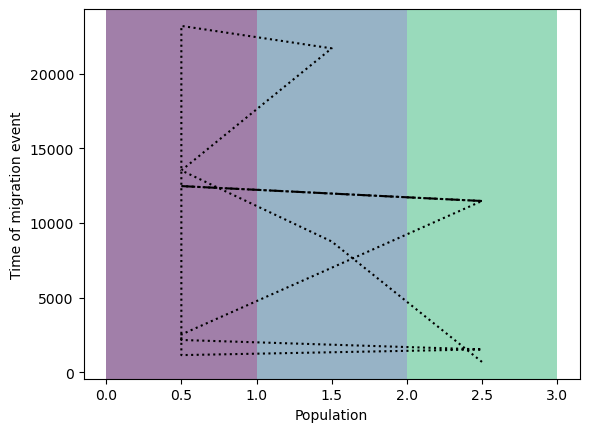

In [67]:
# import tskit
# import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt

# cmap = plt.colormaps['viridis']
# tree = ts.first()
# mig_color_dict = {}
# for u, linestyle in zip(ts.samples()[::2], ["dotted", "dashdot"]):
#     mig = ts.tables.migrations
#     loc = []
#     time = []
#     while u != tskit.NULL:
#         migs = np.where(mig.node == u)[0]
#         for cur_mig in migs:
#             cur_mig = mig[cur_mig]
#             loc.append(cur_mig.dest + 0.5)
#             time.append(cur_mig.time)
#         u = tree.parent(u)
#     plt.plot(loc, time, linestyle=linestyle, color="black")
# for i in range(3):
#     rgba = cmap(i / 3)
#     mig_color_dict[i] = np.array(rgba)*255
#     plt.axvspan(i, i+1, facecolor=rgba, alpha=0.5)
# plt.ylabel("Time of migration event")
# plt.xlabel("Population")
# plt.show()

In [59]:
# ts.migrations.

<bound method TreeSequence.migrations of <tskit.trees.TreeSequence object at 0x14c91eb6a6d0>>

In [68]:
# demography.migration_matrix

array([[0.0e+00, 6.0e-05, 6.0e-05],
       [6.0e-04, 0.0e+00, 1.2e-04],
       [6.0e-04, 1.2e-04, 0.0e+00]])

In [69]:
# def apply_styles(ts): 

#     styles = []
#     # style for each population
#     for colour, p in zip(['red', 'green', 'blue'], ts.populations()):
#         # target the symbols only (class "sym")
#         s = f".node.p{p.id} > .sym " + "{" + f"fill: {colour}" + "}"
#         styles.append(s)
#         #print(f'"{s}" applies to nodes from population {p.metadata["name"]} (id {p.id})')
#     css_string = " ".join(styles)
#     #print(f'CSS string applied:\n    "{css_string}"')

#     colours = {"pop_0": "red", "pop_1": "green", "pop_2": "blue"}
#     colours_for_node = {}
#     for n in ts.samples():
#         population_data = ts.population(ts.node(n).population)
#         colours_for_node[n] = colours[population_data.metadata["name"]]
    
#     individual_for_node = {}
#     for n in ts.samples():
#         individual_data = ts.individual(ts.node(n).individual)
#         individual_for_node[n] = individual_data.id


#     return individual_for_node, css_string

# individual_for_node, css = apply_styles(ts) 
# # individual_for_node_eq, css_eq = apply_styles(ts_eq)

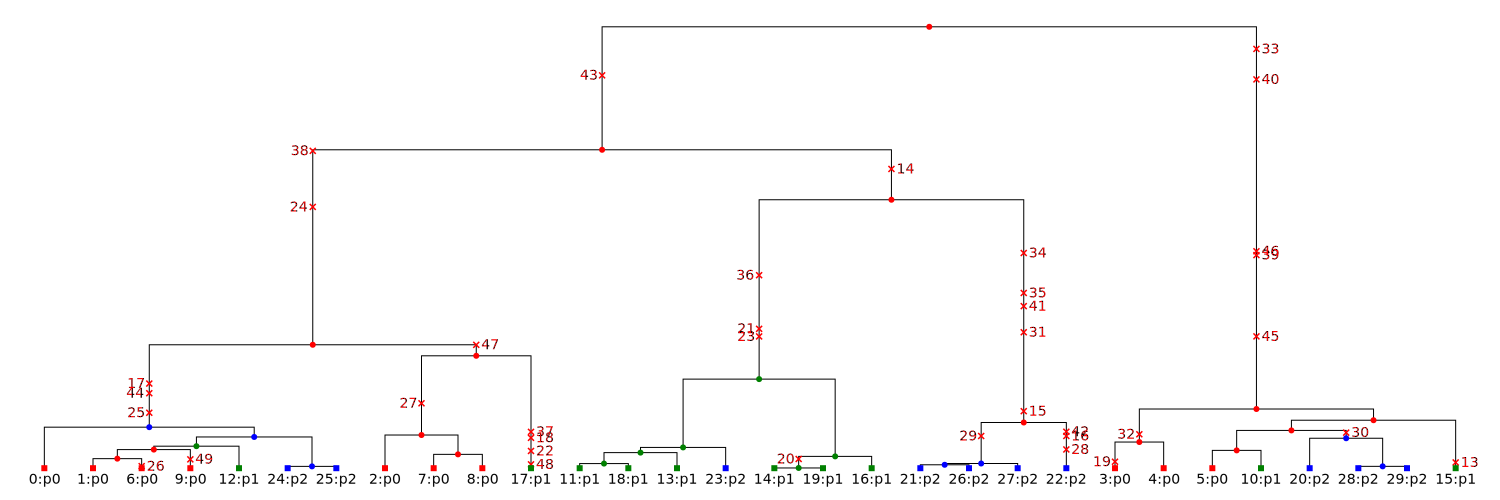

In [70]:
# #Plot with tips labeled by population

# tip_lab = {u: f"{u}:p{ts.node(u).population}" for u in ts.samples()}
# ts.at_index(1).draw_svg(node_labels=tip_lab, style=css, size = (1500,500))